**Population Based Analysis for the US Zip Codes**

References:
 

*   https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
*   https://www.reneshbedre.com/blog/dbscan-python.html

Dataset Source : https://simplemaps.com/data/us-zips

Shapefile Source : https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html



In [13]:
import pandas as pd 
import numpy as np  
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [14]:
df = pd.read_csv('/content/uszips.csv')
df.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18027,-66.75266,Adjuntas,PR,Puerto Rico,True,NaN,16773.0,100.5,72001,Adjuntas,"{""72001"": 98.73, ""72141"": 1.27}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36075,-67.17541,Aguada,PR,Puerto Rico,True,NaN,37083.0,472.1,72003,Aguada,"{""72003"": 100}",Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45744,-67.12225,Aguadilla,PR,Puerto Rico,True,NaN,45652.0,513.2,72005,Aguadilla,"{""72005"": 99.76, ""72099"": 0.24}",Aguadilla|Moca,72005|72099,False,False,America/Puerto_Rico
3,606,18.16585,-66.93716,Maricao,PR,Puerto Rico,True,NaN,6231.0,54.3,72093,Maricao,"{""72093"": 82.26, ""72153"": 11.68, ""72121"": 6.06}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29110,-67.12243,Anasco,PR,Puerto Rico,True,NaN,26502.0,275.7,72011,Añasco,"{""72011"": 96.71, ""72099"": 2.81, ""72083"": 0.37,...",Añasco|Moca|Las Marías|Aguada,72011|72099|72083|72003,False,False,America/Puerto_Rico


In [15]:
df.isna().sum()

zip                     0
lat                     0
lng                     0
city                    0
state_id                0
state_name              0
zcta                    0
parent_zcta         33788
population           1074
density              1074
county_fips             0
county_name             0
county_weights          0
county_names_all        0
county_fips_all         0
imprecise               0
military                0
timezone                0
dtype: int64

In [16]:
df2=df.dropna(subset=['population'])
pop=df2[['zip', 'lat','lng','population']]
pop.head()

,zip,lat,lng,population
0,601,18.18027,-66.75266,16773.0
1,602,18.36075,-67.17541,37083.0
2,603,18.45744,-67.12225,45652.0
3,606,18.16585,-66.93716,6231.0
4,610,18.29110,-67.12243,26502.0


**Remove the unwanted zipcodes included in the dataset**

In [17]:
lat_ext = pop[ (pop['lat'] <= 25) & (pop['lat'] >= 50) ].index
pop.drop(lat_ext , inplace=True)
lng_ext = pop[ (pop['lng'] <= -125) & (pop['lat'] >= -67) ].index
pop.drop(lng_ext , inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Apply DBSCAN**

In [18]:
X = StandardScaler().fit_transform(pop)
coords = pop[['lat', 'lng']].values
db = DBSCAN(eps=0.25, min_samples=2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


Estimated number of clusters: 85
Estimated number of noise points: 145
Silhouette Coefficient: -0.438


In [19]:
# Adding clusters to dataset
pop['clusters']=db.labels_
pop

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,zip,lat,lng,population,clusters
0,601,18.18027,-66.75266,16773.0,0
1,602,18.36075,-67.17541,37083.0,0
2,603,18.45744,-67.12225,45652.0,0
3,606,18.16585,-66.93716,6231.0,0
4,610,18.29110,-67.12243,26502.0,0
...,...,...,...,...,...
33538,99401,46.09041,-117.27336,376.0,3
33539,99402,46.18680,-117.14922,1597.0,3
33540,99403,46.38114,-117.25974,20707.0,3
33786,13021,42.91713,-76.55420,37528.0,3


In [20]:
pop.groupby('clusters').agg(['mean']).reset_index()

,clusters,zip,lat,lng,population
,,mean,mean,mean,mean
0,-1,63911.744828,38.482483,-98.464692,54400.103448
1,0,770.360656,18.271041,-66.361195,22660.852459
2,1,848.000000,18.357690,-66.289937,58874.000000
3,2,951.000000,18.397425,-66.230565,71184.000000
4,3,49146.668420,38.820156,-90.347004,9330.575117
...,...,...,...,...,...
81,80,96475.272727,41.643092,-123.270090,24651.090909
82,81,97080.666667,45.506373,-122.845763,72525.666667
83,82,97502.500000,42.306585,-122.847635,47606.500000


Visualization

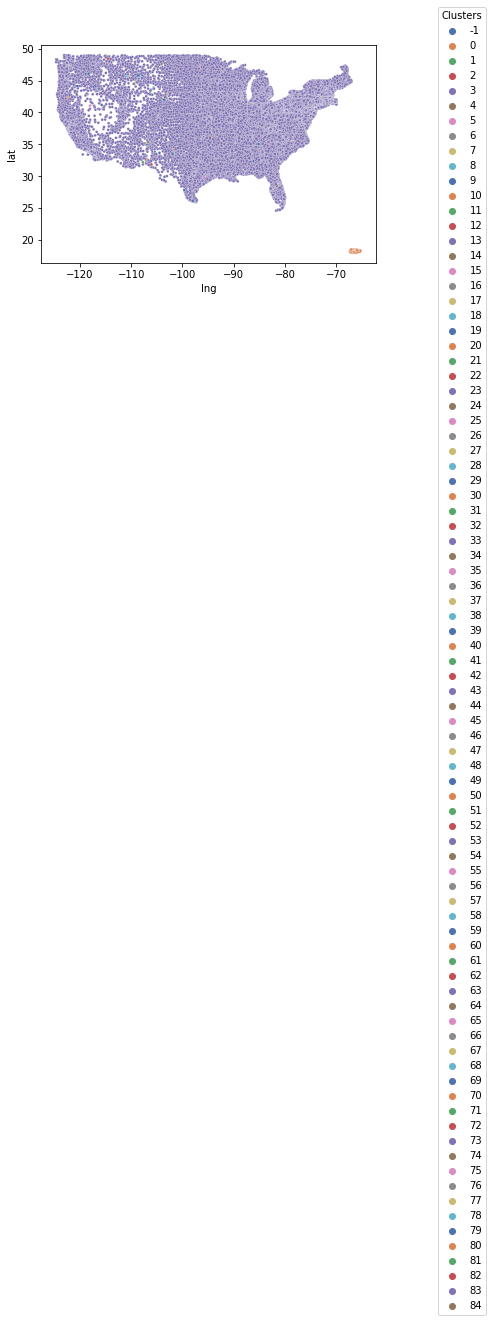

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
p = sns.scatterplot(data=pop, x="lng", y="lat", hue=db.labels_, legend="full", palette="deep", s=8)
sns.move_legend(p, "upper left", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()

**Retrieve the top 10 cities based on population**

In [22]:
out=pop.nlargest(10, ['population'])
out

,zip,lat,lng,population,clusters
27400,77494,29.74566,-95.82302,126310.0,45
27363,77449,29.83674,-95.73547,123157.0,45
26375,75034,33.12084,-96.83778,116155.0,-1
30608,90011,34.00689,-118.25861,110750.0,-1
26401,75070,33.15587,-96.69742,109085.0,-1
28345,79936,31.77373,-106.29631,108668.0,-1
2904,11368,40.74962,-73.85264,108661.0,4
27259,77084,29.82698,-95.66120,108161.0,-1
21125,60629,41.77540,-87.71239,107930.0,-1
2915,11385,40.70103,-73.89011,105025.0,4


**To overlay the zipcodes on the US map**

In [24]:

import geopandas as gpd 
maps = gpd.read_file('/content/usa-states-census-2014.shp')
maps.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


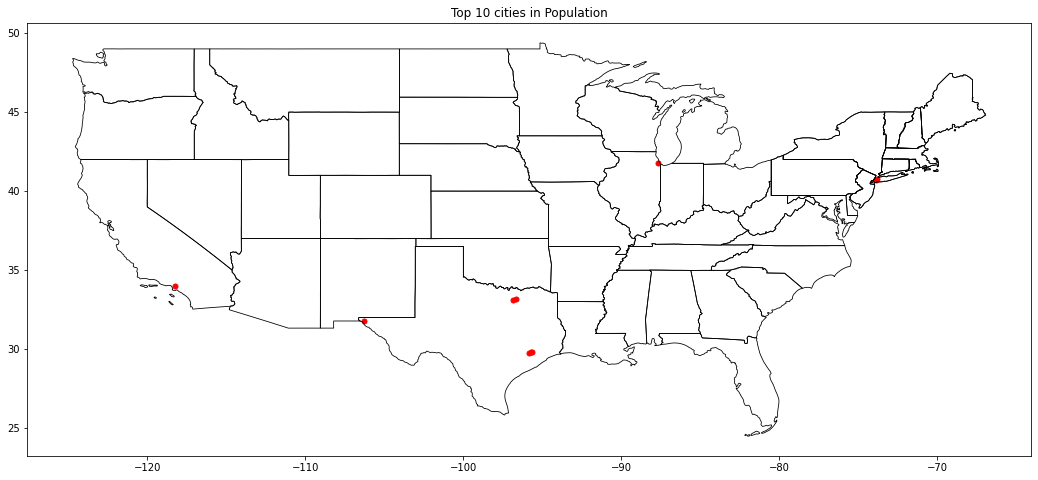

In [25]:

fig = plt.figure(1, figsize=(18,10)) 
ax = fig.add_subplot()
ax.set_title('Top 10 cities in Population')
maps.boundary.plot(ax=ax, color='black', linewidth=.8)
geodf = gpd.GeoDataFrame(out, geometry=gpd.points_from_xy(out.lng, out.lat))
geodf.plot(ax=ax, color='red', marker='.', markersize=100)
plt.show()